In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.datasets import load_iris
from sklearn import tree

In [2]:
#you can simply change the depth here and run everything again.
depth = 2

In [3]:
points = dict()
dataNum = 0
with open('data.txt') as f:
    for line in f:
        dataNum +=1
        x, y, group = line.split(',')
        if '\n' in group:
            group = group[:-1]
        if int(group) not in points:
            points[int(group)] = list()
        points[int(group)].append((float(x),float(y)))




In [4]:
def generateColors(k):
    # generate different colors for each cluster
    colstr = '0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F'
    colset = set()

    for i in range(k):
        color = "#"
        for j in range(6):
            color += np.random.choice(colstr)
        if color not in colset:
            colset.add(color)
    return list(colset)

In [5]:
def calEntropy(bound, left, index, points):
    totalEntropy = 0
    totalLen = 0
    counts = list()
    newPoints = dict()
    for group, pointList in points.items():
        newPointList = list()
        if left:
            newPointList = [point for point in pointList if point[index]<bound]
        else:
            newPointList = [point for point in pointList if point[index]>bound]

        newPoints[group] = newPointList
        counts.append(len(newPointList))
        totalLen += len(newPointList)
    if totalLen != 0:
        probs = np.array(counts)/totalLen
        for prob in probs:
            if prob != 0:
                totalEntropy -= (prob*math.log(prob, 2))
    return totalEntropy, totalLen, newPoints

In [6]:
def findIG(bound, index, points, depth):
    
    dataEntropy, length, points = calEntropy(-math.inf, False,0, points)
    if length == 0:
        return -math.inf, dict(),dict()
    
    leftEntropy, leftL, leftPs = calEntropy(bound, True, index, points)
    
    rightEntropy, rightL, rightPs = calEntropy(bound, False, index, points)
    
    return dataEntropy , leftEntropy, leftL/length, rightEntropy ,rightL/length, leftPs, rightPs

In [7]:
def findBest(points, maxV, minV, depth):
    maxInfoGain = -math.inf
    index, ax = 0,0
    side1Ps, side2Ps = dict(), dict()
    ent, leftEnt, w1, rightEnt, w2 = 0, 0, 0, 0, 0
    for i in np.arange(math.floor(minV[0]), math.ceil(maxV[0]), 0.01):
        entropy, left, wLeft, right, wRight, leftPs, rightPs = findIG(i, 0, points, depth)
        infoGain = entropy - left*wLeft - right*wRight
        if infoGain > maxInfoGain:
            maxInfoGain = infoGain
            index = i
            side1Ps = leftPs
            side2Ps = rightPs
            ent, leftEnt, w1, rightEnt, w2 = entropy, left, wLeft, right, wRight
        
    for i in np.arange(math.floor(minV[1]), math.ceil(maxV[1]), 0.01):
        entropy, left, wLeft, right, wRight, bottomPs, topPs  = findIG(i, 1, points, depth)
        infoGain = entropy - left*wLeft - right*wRight
        if infoGain > maxInfoGain:
            maxInfoGain = infoGain
            index, ax = i, 1
            side1Ps = bottomPs
            side2Ps = topPs
            ent, leftEnt, w1, rightEnt, w2 = entropy, left, wLeft, right, wRight
    
    return index, ax, maxInfoGain, ent, leftEnt, w1, rightEnt, w2,side1Ps, side2Ps
        

In [8]:
def getMaxMin(points):
    maxV, minV = (-math.inf, -math.inf), (math.inf, math.inf)
    for group, pointList in points.items():
        for point in pointList:
            maxV = (max(maxV[0], point[0]),max(maxV[1], point[1]))
            minV = (min(minV[0], point[0]),min(minV[1], point[1]))
    return maxV, minV

In [9]:
def split(points, depth, left, maxDepth, boundaries, entropies):
 
    if depth==maxDepth:
        return

    dataEntropy, length, points = calEntropy(-math.inf, False,0, points)

    if dataEntropy != 0:
        maxV, minV = getMaxMin(points)
        boundary, ax, infoGain, ent, leftEnt, w1, rightEnt, w2, leftPs, rightPs = findBest(points, maxV, minV, depth)
    
        entropies.append("Entropy of the left of level "+str(depth)+": "+ str(leftEnt))
        entropies.append("Entropy of the right of level "+str(depth)+": "+str(rightEnt))
        entropies.append("Weighted Entropy of level "+str(depth)+": "+ str(leftEnt*w1 + rightEnt*w2))

        boundaries.append((boundary,depth, ax,infoGain, dataEntropy, maxV, minV))
        depth += 1
        split(leftPs, depth, True, maxDepth, boundaries, entropies)
        split(rightPs, depth, False, maxDepth, boundaries, entropies)
        

In [10]:
def plotData(points, colorset):
    i = 0
    for group, pointList in points.items():
        for point in pointList:
            plt.scatter(point[0], point[1], color=colorset[i])
        i += 1

In [11]:
def execute(data, depth):
    colorset = generateColors(len(data))
    boundaries = list()
    entropies = list()
    dataEntropy, length, points = calEntropy(-math.inf, False,0, data)
    entropies.append("Level 0 Entropy: " + str(dataEntropy))
    split(data, 0,None, depth, boundaries, entropies)    
    i = 0
    for entropy in entropies:
        print(entropy)
    for group, pointList in data.items():
        for point in pointList:
            plt.scatter(point[0], point[1], color=colorset[i])
        i += 1
    colorset = generateColors(len(boundaries))
    lines = list()
    labels = list()
    for ind, bound in enumerate(boundaries):
        loc,level, ax, infoGain, entropy, maxV, minV = bound
        label = "Boundary"+str(level+1)+"\n"
        if ax==0:
            label += "x = "+str(loc)[:6]
            plt.vlines(loc, minV[1], maxV[1], color=colorset[ind],label=label )
        else:
            label += "y = "+str(loc)[:6] 
            plt.hlines(loc, minV[0], maxV[0], color=colorset[ind],label=label )

    plt.legend(loc=2, prop={'size': 7})
    plt.show()

In [12]:
def sklearnComp(data, depth):
    X=list()
    y= list()
    for group, pointList in data.items():
        X +=pointList 
        y += [group]*len(pointList)
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=depth)
    clf = clf.fit(X, y)
    tree.plot_tree(clf)

Level 0 Entropy: 0.9117517586347538
Entropy of the left of level 0: 0.9940302114769565
Entropy of the right of level 0: 0.0
Weighted Entropy of level 0: 0.595780928032663
Entropy of the left of level 1: 0.0
Entropy of the right of level 1: 0.899349319724299
Weighted Entropy of level 1: 0.71659384298888


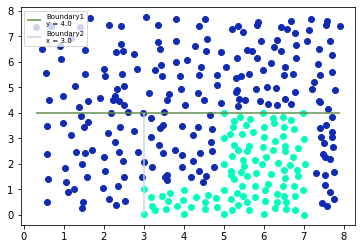

In [13]:
execute(points, depth)

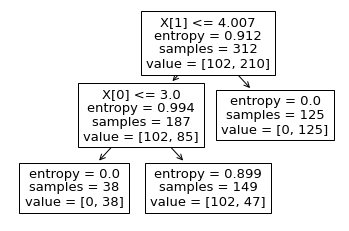

In [14]:
sklearnComp(points,depth)

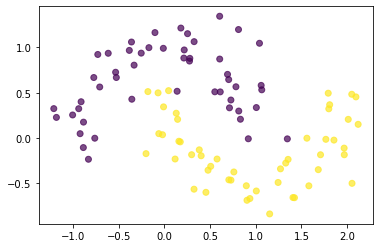

In [15]:
from sklearn.datasets import make_moons

dataset = make_moons(noise=0.2, random_state=0)
            
X, y = dataset
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.7)


Level 0 Entropy: 1.0
Entropy of the left of level 0: 0.8760643678555243
Entropy of the right of level 0: 0.0
Weighted Entropy of level 0: 0.6220057011774223
Entropy of the left of level 1: 0.0
Entropy of the right of level 1: 0.6500224216483541
Weighted Entropy of level 1: 0.5493147225197359
Entropy of the left of level 2: 0.0
Entropy of the right of level 2: 0.961236604722876
Weighted Entropy of level 2: 0.4165358620465796
Entropy of the left of level 3: 0.9910760598382222
Entropy of the right of level 3: 0.0
Weighted Entropy of level 3: 0.6861295798879999


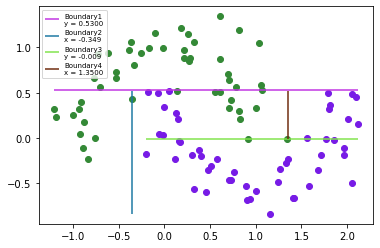

In [16]:
myData = dict()
for i,group in enumerate(y):
    if group not in myData:
        myData[group] = list()
    myData[group].append(X[i])
execute(myData, 4)  

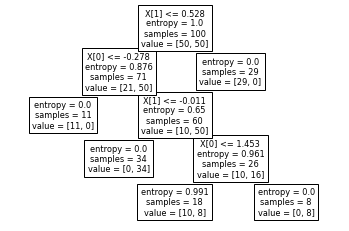

In [17]:
sklearnComp(myData,4)